**Note, when viewing this file on GitHub, the MathJax (and other things) can be a little wonky /:**<br>
**For better formatting, I suggest you read this file on Deepnote:**<br>
<b><a href="https://deepnote.com/viewer/github/martinm07/tokenization-layer/blob/main/concept-explained.ipynb">Read this file on Deepnote</a></b>

In [1]:
# General libraries
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

# ML & DL libraries
import tensorflow as tf
from tensorflow import keras
print(f"TensorFlow version: {tf.__version__}")

# Misc libraries
import textwrap
import re
import string
from copy import copy
import time
from IPython.display import clear_output
import os
from colorama import Fore

TensorFlow version: 2.5.0


In [2]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

# Introduction

*Tokenization* is the first basic step in almost any natural language processing pipeline. Tokenization is the process of splitting up text into smaller chunks. We do this because for someone or something to see a brand new text (for example a book) and "read" it, they need to link it to stuff they've seen before and know the meaning of (e.g. words or phrases). Then, they build up the meaning of the text from there, *inferring* the meaning using the rules of natural language.<br>
This "*stuff they've seen before*" is *tokens*. Tokens (for an algorithm) make up the building blocks of natural language. It's what they use to construct the meaning of any text, using the rules of natural language (which they have to learn).<br>
So, as you can probably guess, tokenization is a vital part of the pipeline, and in this notebook, we will attempt a new kind of tokenization, training the tokenization algorithm like a layer in the neural network we want to have one for. Let's dive in.

The process of tokenization is *splitting up the text*, however we can think of it as "finding tokens in the text" too:

In [3]:
example_text = 'Hello and welcome to this exquisite passage of text who\'s solemn purpose is to act in place of a real piece of text, what is known as an "example".'
tokens = ["and", "to", "this", "is", "in", "of", "a", "as", "an", "place", "passage", "text", 
          "example", "known", "welcome", "purpose"]

In [4]:
def tokenizer(tokens, text):
    tokens_sorted = list(pd.Series([len(token) for token in tokens], index=tokens).sort_values(ascending=False).keys())
    out = pd.Series(dtype="object")
    for token in tokens_sorted:
        token_inds = [m.start() for m in re.finditer(re.escape(token), text)]
        out = pd.concat([out, pd.Series(token, index=token_inds)])
        text = text.replace(token, " ".join(["" for _ in range(len(token)+1)]))
    return list(out.sort_index().values)

In [5]:
example_text_tokenized = tokenizer(tokens, example_text)

In [6]:
print(Fore.BLUE+"Tokenizes the text"+Fore.RESET)
for line in textwrap.wrap(example_text, width=118):
    print(line)
print(Fore.BLUE+"into:"+Fore.RESET)
for line in textwrap.wrap(str(example_text_tokenized), width=118):
    print(line)
print(Fore.BLUE+"Using the tokens:"+Fore.RESET)
for line in textwrap.wrap(str(tokens), width=118):
    print(line)

Tokenizes the text
Hello and welcome to this exquisite passage of text who's solemn purpose is to act in place of a real piece of text,
what is known as an "example".
into:
['and', 'welcome', 'to', 'this', 'is', 'passage', 'of', 'text', 'purpose', 'is', 'to', 'a', 'in', 'place', 'of', 'a',
'a', 'of', 'text', 'a', 'is', 'known', 'as', 'an', 'example']
Using the tokens:
['and', 'to', 'this', 'is', 'in', 'of', 'a', 'as', 'an', 'place', 'passage', 'text', 'example', 'known', 'welcome',
'purpose']


This is an easier way of thinking about it when dealing with more complex tokenization (i.e. more than "split by the whitespace").<br>
Now, this is like a function, which, using a list of tokens, can take in some text and tokenize it using the tokens. To do that we just need a list of tokens to use. Actually getting such a list is the meat of the problem.

One possible way of doing this is to try optimize a list of (intially random) tokens. To do this we could actually make a "tokenization layer", that goes at the frony of a neural network trying to solve some NLP task (and subsequently needs tokens). Then, the list of tokens trains along with the rest of the network. Let's define this layer.

# Defining the Neuron

The tokenization neuron is made up of a pattern, and a signature (named "out"). When it takes in an input, it looks for matches of the pattern in the input, and then returns it's signature, "out", at these matches, with $0$ everywhere else to make it the same length as the input.<br>
The input of this neuron would be one-hot encoded, having the shape `(num_categories, sequence_len)`. Typically, the input would be the text input of the neural network you're trying to train, and it would be one-hot encoded as characters, so `num_categories` is the number of different characters in the text. The neuron's pattern is then also the same scheme, having shape `(num_categories, pattern_len)`.

### Let's look at an example

Firstly, we have our text data we want to feed our neuron:
$$
\text{text = "a bad cab"}
$$
We need to one-hot encode it first:
$$
\text{"a"}=
\begin{bmatrix} 
1 \\ 
0 \\ 
0 \\ 
0 \\ 
0 
\end{bmatrix} 
\text{, "b"}=
\begin{bmatrix} 
0 \\ 
1 \\ 
0 \\ 
0 \\ 
0 
\end{bmatrix} 
\text{, "c"}=
\begin{bmatrix} 
0 \\ 
0 \\ 
1 \\ 
0 \\ 
0 
\end{bmatrix} 
\text{, "d"}=
\begin{bmatrix} 
0 \\ 
0 \\ 
0 \\ 
1 \\ 
0 
\end{bmatrix} 
\text{, " "}=
\begin{bmatrix} 
0 \\ 
0 \\ 
0 \\ 
0 \\ 
1 
\end{bmatrix}
$$

$$
\text{text}=\begin{bmatrix} 1&0&0&1&0&0&0&1&0 \\ 0&0&1&0&0&0&0&0&1 \\ 0&0&0&0&0&0&1&0&0 \\ 0&0&0&0&1&0&0&0&0 \\ 0&1&0&0&0&1&0&0&0 \end{bmatrix}
$$
Now, let's say our neuron's pattern and signature ("out") is:
$$
\text{pattern} = \begin{bmatrix} 0&1&0 \\ 1&0&0 \\ 0&0&0 \\ 0&0&1 \\ 0&0&0 \end{bmatrix} 
\text{, out} = \begin{bmatrix} 1 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}
$$
When our neuron gets the text input it returns:
$$
f(text, pattern, out) = \text{return  }
text
\text{  of 0s except with  }
out
\text{  where  }
pattern
\text{  in  }
text
$$

$$
f(\text{text}, \text{pattern}, \text{out}) = \begin{bmatrix} 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix}
$$

# Defining the Layer

Now, this is one neuron, how do we make a tokenization "layer"? Well, our layer is made up of a stack of neurons, each neuron has it's own $\text{pattern}$ and $\text{out}$, and all take in the same input. All the neurons individually output their own "version" of the text, all only keeping what the pattern recognized, signified by that neuron's $\text{out}$, which will follow the same scheme as the input, having the shape `(num_neurons, 1)`, with $1$ at one index and $0$ at every other. This is so that, when getting the output of the layer itself, we can just add up (element-wise) the outputs of all the neurons.<br>
Here's an example of what this layer would look like in practice (note that $f_n$ is the $n$th neuron, $p_n$ is the $n$th pattern, $o_n$ is the $n$th out and $t$ is the input text):

$$
f_1(t, p_1, o_1) = \begin{bmatrix} 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix}
, f_2(t, p_2, o_2) = \begin{bmatrix} 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix}
, f_3(t, p_3, o_3) = \begin{bmatrix} 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix}
$$

$$
, f_4(t, p_4, o_4) = \begin{bmatrix} 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix}
, f_5(t, p_5, o_5) =  \begin{bmatrix} 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix}
$$

$$
\text{layer output} = f_1(t, p_1, o_1) + f_2(t, p_2, o_2) + f_3(t, p_3, o_3) + f_4(t, p_4, o_4) + f_5(t, p_5, o_5) = 
\begin{bmatrix}0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 \\ 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
$$

You can imagine how this would work for a tokenization algorithm; the patterns are like tokens, and the layer output is a representation of the text with said tokens.<br>
Now, while this is all well and good, we still need something if we want to *train* this; and that's the derivatives.<br>
Neural networks are trained through a process called *gradient descent*, I won't go into the intuition but this requires the derivatives at different parts of the neural network. That means, to train this layer, we need to know it's *derivative*, which, is hard to do as it's not well mathematically defined. Luckily, we can mathematically define it.

# Finding the Derivative

This neuron is actually pretty similar to *convolutions* (from CNNs), and we can redefine our neuron to use them here.<br>
Here's what the convolution operation actually is:

$$
\begin{bmatrix}
x_{11} & x_{12} & x_{13} \\
x_{21} & x_{22} & x_{23} \\
x_{31} & x_{32} & x_{33} \\
\end{bmatrix} * 
\begin{bmatrix}
f_{11} & f_{12} \\
f_{21} & f_{22} 
\end{bmatrix} = 
\begin{bmatrix}
o_{11} & o_{12} \\
o_{21} & o_{22} \\
\end{bmatrix}
$$

$$o_{11} = f_{11}x_{11}+f_{12}x_{12}+f_{21}x_{21}+f_{22}x_{22}$$ $$o_{12} = f_{11}x_{12}+f_{12}x_{13}+f_{21}x_{22}+f_{22}x_{23}$$ $$o_{21} = f_{11}x_{21}+f_{12}x_{22}+f_{21}x_{31}+f_{22}x_{32}$$ $$o_{22} = f_{11}x_{22}+f_{12}x_{23}+f_{21}x_{32}+f_{22}x_{33}$$

<img style="width: 60%; margin-left: 20%;" src="https://miro.medium.com/max/1050/1*K7dINARev0NUB-HWp9mbwA.gif">

<p style="text-align: center;"><i>Credit for GIF goes to (as far as I can tell) <a href="https://medium.com/@pavisj">Pavithra Solai</a>, who also<br>has a <a href="https://medium.com/@pavisj/convolutions-and-backpropagations-46026a8f5d2c">great article</a> for those getting started with convolutions.</i></p>

As you can see, we simply "slide" the filter over the input, multiplying the values element-wise and adding them up at each step.<br>
If we say our pattern is the filter $F$, and the input text is $X$, we get something similar to what we defined our neuron to be before. Let us see with an example:

$$
\begin{bmatrix}
1&0&0&1&0&0&0&1&0 \\
0&0&1&0&0&0&0&0&1 \\
0&0&0&0&0&0&1&0&0 \\
0&0&0&0&1&0&0&0&0 \\
0&1&0&0&0&1&0&0&0
\end{bmatrix} * \begin{bmatrix}
0&1&0 \\
1&0&0 \\
0&0&0 \\
0&0&1 \\
0&0&0
\end{bmatrix} = \begin{bmatrix}
0 & 0 & 3 & 0 & 0 & 0 & 1
\end{bmatrix}
$$

Remebering what the output of this neuron should be, this is pretty close! Where the $3$ is here is where the neuron found a full match with the pattern (because all *three* letters in the pattern matched). So, we could re-define our neuron to be this:
$$
f(text, pattern, out) = \frac{text * pattern}{len(pattern)} \text{ with }out\text{ where }== 1
$$
However, a lot of it is redundant (as we won't be changing $out$), so all we really have to optimize (i.e. get the derivative) for is:

$$
\frac{text * pattern}{len(pattern)}
$$

You could see how optimizing $pattern$ in this version of the neuron would result in similar optimization in the actual version of forward propagation that we'll be using.<br>
I won't go into the details of deriving the convolution (there's other places for that), so here would be the derivatives with respect to $pattern$ and $text$:

$$
\frac{\partial C}{\partial pattern} = \frac{\partial C}{\partial f} \cdot \frac{\partial f}{\partial pattern} = \frac{\partial C}{\partial f} \cdot \frac{\partial}{\partial P}[\frac{text * pattern}{len(pattern)}]
$$

$$
 = \frac{text * \frac{\partial C}{\partial f}}{len(pattern)}
$$

<br>

$$
\frac{\partial C}{\partial text} = \frac{\partial C}{\partial f} \cdot \frac{\partial f}{\partial text} = \frac{\partial C}{\partial f} \cdot \frac{\partial}{\partial text}[\frac{text * pattern}{len(pattern)}]
$$

$$
 = \frac{pad(\frac{\partial C}{\partial f}) * rot180(pattern)}{len(pattern)}
$$

Here, we're getting the derivative of the (theoretical) cost $C$ with respect to $pattern$ and $text$. By way of the chain rule, this is the same as $\frac{\partial C}{\partial f} \cdot \frac{\partial f}{\partial \text{parameter}}$, and from there we can get the derivatives.

# The Finer Details

There are some problems with what we've discussed so far.<br>
For one thing; *changing $pattern$*; we want to change $pattern$ as to minimize the cost (using gradient descent), however, gradient descent *expects* $pattern$ to be continuous (as in, it could be any real number), but $pattern$ is meant to be a one-hot encoding like the text! We can solve this by saying that what gradient descent is trying to optimize *is* continuous, let's call it $p_{\text{intermediate}}$, and we derive $pattern$ from $p_{\text{intermediate}}$ by saying that, for every column, the highest value is where there'll be the $1$, and everything else is $0$.

$$
p_{\text{intermediate}} = \begin{bmatrix}
0.93 & 0.18 & 0.38 \\
0.49 & 0.79 & 0.80 \\
0.76 & 0.85 & 0.13 \\
0.82 & 0.65 & 0.16 \\
0.83 & 0.42 & 0.08
\end{bmatrix} \longmapsto p = \begin{bmatrix}
1 & 0 & 0 \\
0 & 0 & 1 \\
0 & 1 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
\end{bmatrix}
$$

Additionally, we would also like the pattern to *not* contain characters in some places (i.e. columns of just $0$s). To do this, we can add an extra rule saying that "if the sum of all the values in a column is less than (or equal to) $0$, then that column will not contain a character and just be $0$s"

However, this creates another problem; it's now very easy for gradient descent to make no-character characters in tokens, perhaps *too* easy. We would like to control just how easy it is to make no-character characters, and to do that, we can simply multiply the gradient $\partial C / \partial P$ by $\sigma (P)$, where

$$
\sigma(x) = \begin{cases}
0 & x \leq 0 \\
\frac{x^{\left(-\beta -1\right)}}{\left(1+x^{-\beta}\left(1-x\right)^{\beta}\right)^{2}\left(-x+1\right)^{\left(-\beta +1\right)}} & 0 < x < 1 \\
0 & x \geq 1 \\
\end{cases}
$$

This is the graph of the function:

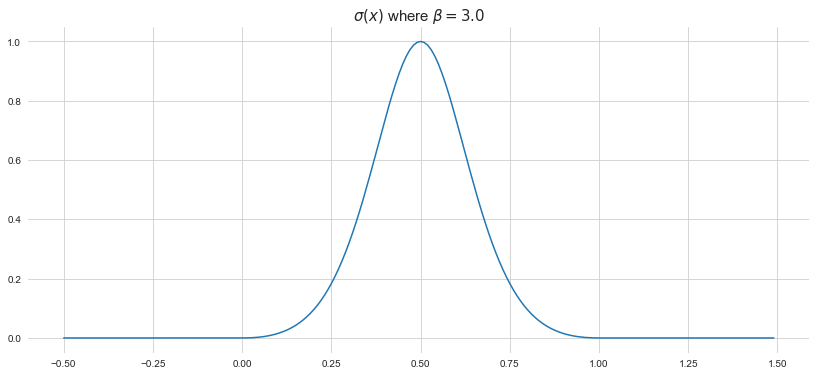

In [7]:
def sigma(x, b=3.0):
    if x <= 0:
        return 0.
    elif x >= 1:
        return 0.
    else:
        return (x**(-b-1)) / ((1 + x**(-b) * (1 - x)**b)**2 * (-x + 1)**(-b+1))

vals = [sigma(x) for x in np.arange(-0.5, 1.5, 0.01)]

plt.figure(figsize=(14, 6))
plt.title(r"$\sigma (x)$ where $\beta = 3.0$", fontdict={"fontsize":15})
plt.plot(np.arange(-0.5, 1.5, 0.01), vals);
sns.despine(left=True, bottom=True)

With this, when a value $p \in P$ approaches the two values it actually *can* be (i.e. $0$ or $1$), the gradient shrinks, slowing down updates and keeping $p$ within the range $(0,1)$. However we would like *some* negative values, and to do that we can add another controllable parameter $\alpha$, where the range of $p$ is then $(\alpha, 1)$:

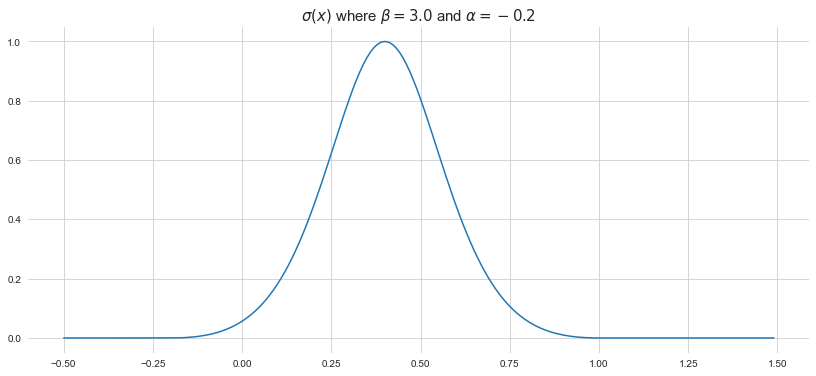

In [8]:
def bump_func_leaky(x, a=-0.2, b=3.0):
    a = -a/(-a+1)
    if x <= (-1/(1-a) + 1):
        return 0.
    elif x >= 1:
        return 0.
    else:
        x = (1-a)*x + a
        return (x**(-b-1)) / ((1 + x**(-b) * (1 - x)**b)**2 * (-x + 1)**(-b+1))

vals = [bump_func_leaky(x) for x in np.arange(-0.5, 1.5, 0.01)]

plt.figure(figsize=(14, 6))
plt.title(r"$\sigma (x)$ where $\beta = 3.0$ and $\alpha = -0.2$", fontdict={"fontsize":15})
plt.plot(np.arange(-0.5, 1.5, 0.01), vals);
sns.despine(left=True, bottom=True)

Okay, let's start doing some code.

# Coding it Out

First thing's first, we need a natural language processing task that we would need tokenization for. Here, I pick the [IMDB Movie Reviews](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) dataset (very *exotic*, I know), where we must predict if reviews were positive or negative towards the movie. Let's get the data and do some basic preprocessing:

In [9]:
data = pd.read_csv("IMDB Dataset.csv")
data = data.sample(len(data)).reset_index(drop=True)

# Strip "<br />" tags and convert to lowercase
data["review"] = data["review"].apply(lambda x: x.replace("<br />", " ").lower())
# Strip punctuation
data["review"] = data["review"].apply(lambda x: re.sub(f"[{string.punctuation}]", "", x))
# Get top 30 most common characters
chars = "".join(pd.Series(list(" ".join(data["review"].to_list()))).value_counts().keys()[:30])
# Remove everything except the top 30 most common characters
data["review"] = data["review"].apply(lambda x: re.sub(f"[^{chars}]", "", x))

from sklearn.preprocessing import OrdinalEncoder
data[["sentiment"]] = OrdinalEncoder().fit_transform(data[["sentiment"]])

print(data.head())

                                              review sentiment
0  why did i waste my time with this movie there ...       0.0
1  in the middle of the hole i emailed a friend o...       1.0
2  the preposterous premise of this flick has to ...       0.0
3  quite possibly the nicest woman in show busine...       0.0
4  probably the only thing that got the movie up ...       0.0


Now, let's split it into a train, test and validation set:

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_val, y_train, y_val = train_test_split(data["review"], data["sentiment"], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

Finally, let's convert these to TensorFlow datasets and do the final preprocessing (i.e. one-hot encoding the characters and padding them to be the same length), as well as batching it to length 32:

In [12]:
@tf.function
# Encode characters into integers
def ordinal_encode(x):
    split = tf.strings.bytes_split(x)
    chars_tensor = tf.constant(list(chars))
    return tf.argmax(tf.map_fn(lambda x: chars_tensor==x, split, dtype=tf.bool), axis=1)

# One-hot encode integers
def onehot(x):
    return tf.transpose(tf.one_hot(x, depth=len(chars)))

# Clip and pad all reviews to be 2000 characters long
def clip_and_pad(x):
    output_length = 2000
    shape = tf.shape(x)
    if shape[1] >= output_length:
        return x[:, :output_length]
    else:
        return tf.concat([x, tf.zeros((shape[0], output_length-shape[1]))], axis=1)

X_train, X_val, X_test = tf.data.Dataset.from_tensor_slices(X_train), tf.data.Dataset.from_tensor_slices(X_val), tf.data.Dataset.from_tensor_slices(X_test)
X_train, X_val, X_test = X_train.map(ordinal_encode).map(onehot).map(clip_and_pad), X_val.map(ordinal_encode).map(onehot).map(clip_and_pad), X_test.map(ordinal_encode).map(onehot).map(clip_and_pad)

y_train, y_val, y_test = tf.data.Dataset.from_tensor_slices(np.asarray(y_train).astype('float32')), tf.data.Dataset.from_tensor_slices(np.asarray(y_val).astype('float32')), tf.data.Dataset.from_tensor_slices(np.asarray(y_test).astype('float32'))

train_set, val_set, test_set = tf.data.Dataset.zip((X_train, y_train)), tf.data.Dataset.zip((X_val, y_val)), tf.data.Dataset.zip((X_test, y_test))
for item in train_set.take(3):
    print(item)

train_set = train_set.shuffle(buffer_size=1000, seed=42, reshuffle_each_iteration=False) \
                     .batch(32, drop_remainder=True).prefetch(1)
val_set = val_set.shuffle(buffer_size=1000, seed=42, reshuffle_each_iteration=False) \
                     .batch(32, drop_remainder=True).prefetch(1)
test_set = test_set.shuffle(buffer_size=1000, seed=42, reshuffle_each_iteration=False) \
                     .batch(32, drop_remainder=True).prefetch(1)

train_set = train_set.map(lambda x, y: (tf.expand_dims(x, 3), y))
val_set = val_set.map(lambda x, y: (tf.expand_dims(x, 3), y))
test_set = test_set.map(lambda x, y: (tf.expand_dims(x, 3), y))

Instructions for updating:
Use fn_output_signature instead
(<tf.Tensor: shape=(30, 2000), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)
(<tf.Tensor: shape=(30, 2000), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)
(<tf.Tensor: shape=(30, 2000), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
    

In [13]:
char_lookup = tf.concat([tf.constant(["█"]), tf.strings.bytes_split(tf.constant(chars))], axis=0)
reverse_text = lambda x: tf.strings.join(tf.gather(char_lookup, tf.argmax(tf.concat([tf.fill([1, x.shape[1]], 0.5), x], axis=0), axis=0)))

Now, we need to figure out how to initialize the patterns for the tokenization layer.<br>
There's many ways to do it, however, a *good* pattern probably appears many times in the $text$, so here I'll intialize $patterns$ by getting all the n-grams (with "n" being the length of the pattern) in a corpus of text, then I rank the grams by how common it was in the corpus, and finally choose a gram randomly (with higher-ranking grams having a higher probability). When encoding these grams, we can't just one-hot encode it, as our $\sigma (x)$ (shown in the section "The Finer Details") we use when updating the patterns will make it so that $0$s and $1$s basically *never* update. So, instead, we one-hot encode it and say that zeros are instead values coming from a normal distribution with $\sigma = 0.25$ and $\mu = 0.08$ (i.e. mean and standard deviation), and ones are insead values coming from a normal distribution with $\sigma = 0.75$ and $\mu = 0.08$.

In [14]:
def gram_count_batch(gram_len=10, filter_over=1):
    gram_text = lambda x: tf.strings.ngrams(tf.strings.bytes_split(x), gram_len, separator="")
    def return_func(x):
        grammed_batch = tf.ragged.map_flat_values(gram_text, x)
        flattened_batch = grammed_batch.merge_dims(0, -1)
        y, idx, count = tf.unique_with_counts(flattened_batch)
        filter_ = tf.squeeze(tf.where(count > filter_over), 1)
        filtered_y = tf.gather(y, filter_)
        filtered_count = tf.gather(count, filter_)
        return (filtered_y, filtered_count)
    return return_func

def one_hot_str(string):
    return tf.transpose(tf.map_fn(lambda x: tf.cast(tf.constant(list(chars))==x, tf.int32), 
                        tf.strings.bytes_split(string), fn_output_signature=tf.int32))

In [15]:
X_train, X_val, y_train, y_val = train_test_split(data["review"], data["sentiment"], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
X_train_data = tf.data.Dataset.from_tensor_slices(X_train)
X_train_batched = X_train_data.batch(1000)

In [16]:
class PatternsInitilizerMaxCover(keras.initializers.Initializer):
    # Provide a list of possible pattern lengths (as `gram_lens`), when making a pattern it 
    # randomly chooses a length for that pattern (with uniform probability) from `gram_lens`.
    def __init__(self, gram_lens, filter_over=1):
        self.all_grams_dict, self.probs_dict = {}, {}
        self.gram_lens = gram_lens
        # Find the unique grams and their frequenicies for all gram_lens provided
        for gram_len in self.gram_lens:
            # Get all unique grams and their counts (in batches, because all at once eats the RAM)
            X_train_batch_counted = X_train_batched.map(gram_count_batch(gram_len=gram_len, filter_over=filter_over))
            gram_counts_batched = []
            for batch in X_train_batch_counted:
                gram_counts_batched.append(batch)
            df = pd.DataFrame(gram_counts_batched)
            # Concatenate batches together
            all_counts = tf.concat(df[1].to_list(), axis=0)
            all_grams = tf.concat(df[0].to_list(), axis=0)
            # Normalize the counts to get the "probabilites"
            probs = tf.expand_dims(all_counts / tf.reduce_sum(all_counts), 0)
            # Save the unique grams and their proabilities
            self.all_grams_dict[gram_len], self.probs_dict[gram_len] = all_grams, probs
    
    def __call__(self, shape, **kwargs):
        patterns = []
        # For every tokenization neuron:
        for neuron in range(shape[3]):
            # Choose a length for the pattern at random
            pattern_len = np.random.choice(self.gram_lens)
            # Choose a random gram of specified `pattern_len`
            pattern = tf.gather(self.all_grams_dict[pattern_len], tf.random.categorical(tf.math.log(self.probs_dict[pattern_len]), 1))[0, 0]
            # One-hot encode, pad, and save pattern
            pattern_onehot = tf.cast(one_hot_str(pattern), tf.float32)
            padding = tf.zeros((pattern_onehot.shape[0], max(self.gram_lens)-pattern_len))
            patterns.append(tf.concat([pattern_onehot, padding], axis=1))
        # Concatenate patterns to make final tensor
        patterns = tf.expand_dims(tf.transpose(tf.stack(patterns), [1, 2, 0]), 2)
        # Replace 0s and 1s with random values from differnet distributions respectively
        return tf.where(patterns==0., tf.random.normal(patterns.shape, mean=0.25, stddev=0.08),
                                      tf.random.normal(patterns.shape, mean=0.75, stddev=0.08))
    def get_config(self):
        return {"gram_len": gram_len, "filter_over": filter_over}

As an example, here's some patterns this initialization makes (I made them only length 10 to save on compute):

In [17]:
gram_len, filter_over = 10, 1
X_train_batch_counted = X_train_batched.map(gram_count_batch(gram_len=gram_len, filter_over=filter_over))
gram_counts_batched = []
for batch in X_train_batch_counted:
    gram_counts_batched.append(batch)
df = pd.DataFrame(gram_counts_batched)
all_counts = tf.concat(df[1].to_list(), axis=0)
all_grams = tf.concat(df[0].to_list(), axis=0)
probs = tf.expand_dims(all_counts / tf.reduce_sum(all_counts), 0)
tf.gather(all_grams, tf.random.categorical(tf.math.log(probs), 100))

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


<tf.Tensor: shape=(1, 100), dtype=string, numpy=
array([[b'se people ', b' to the sc', b'll asleep ', b'lot elemen',
        b' years old', b'e movie is', b'onstrated ', b'somewhere ',
        b'ide from s', b'ey needed ', b'reenplay a', b' technique',
        b'daptation ', b'me i think', b'roduction ', b'ast of the',
        b' mini film', b'isnt anyth', b'tch the fi', b'e excellen',
        b'his case i', b' it was hi', b'ing this m', b'ssible to ',
        b'the photog', b'ose ends a', b'nd speakin', b'reality th',
        b'r understa', b'acters tha', b'e kinds of', b'orking on ',
        b'the script', b'n actor an', b'sterpiece ', b' brigante ',
        b' dont unde', b'ason is be', b'cal christ', b'eaves with',
        b'ound effec', b' humor tha', b'unusual th', b'in the ita',
        b' of what i', b'ith the ma', b' scenes we', b't the rest',
        b't see the ', b'ealistic t', b' several o', b'and someti',
        b' to be one', b'at the ver', b'ing skills', b'worth watc',

Then, let's define $\sigma (x)$:

In [18]:
def bump_func(x, a=-0.2, b=2.5):
    a = -a/(-a+1)
    x = (1-a)*x + a
    return (x**(-b-1)) / ((1 + x**(-b) * (1 - x)**b)**2 * (-x + 1)**(-b+1))

@tf.function
def tokenization_transformation(x):
    out_zeros = tf.where((x <= 0.) | (x >= 1.), 0., x)
    out_smoothstep = tf.where((out_zeros > 0) & (out_zeros < 1), bump_func(out_zeros), out_zeros)
    return out_smoothstep

Now, let's make the tokeniation layer itself:

In [19]:
@tf.custom_gradient
def tokenization(input_, patterns):
    # `upstream` will have shape (batch_size, output_height/num_neurons, output_width/input_width, 1)
    #     (you can imagine why output_height would be the same as num_neurons as "the text is now 
    #      being represented by `num_neurons` neurons, and each neuron has it's one-hot encoding, 
    #      thus, height=num_neurons". 
    #      We also specifically padded output_width to be the same as input_width in forward 
    #      propagation).
    def grad(upstream):
        # The first thing we need to do in backprop is make upstream to be as if it was
        # made using just a convolution operation (in forward prop). So, we remove the padding
        # we added in forward prop and transpose the dimensions a bit
        amount_not_padding = tf.shape(upstream)[2] - tf.shape(patterns)[1] + 1
        upstream = upstream[:, :, :amount_not_padding]
        upstream = tf.transpose(upstream, [0, 3, 2, 1])
        # Then, we need to get the gradients w.r.t. `input_` and `patterns`, pretending that forward
        # prop was just a convolution of `patterns` on `input`.
        with tf.GradientTape() as tape:
            tape.watch(input_)
            tape.watch(patterns)
            z = tf.nn.convolution(input_, patterns) * upstream # Note how we multiply (element-wise)
            # with `upstream`!
        grads = tape.gradient(z, [input_, patterns])
        # Finally, we return the gradients (remembering to multiply the patterns' gradients 
        # element-wise with sigma(x)).
        return grads[0], grads[1]*tokenization_transformation(patterns)
    
    # The `patterns` parameter is just arbritrary numbers. We want `patterns` to be able to match
    # the text. For that each column must contain one "1" and the rest be zeros
    # (one-hot encoding), to make that we take the maximum value in each column and say that's
    # the "1". We would also like there to be columns that are ignored. Those columns would be
    # filled with just zeros. To do that, we say that if the sum of all the values in a column
    # is less than (or equal to) 0, that column if filled with just zero.
    patterns_discrete = tf.cast(tf.math.logical_and(
        patterns == tf.expand_dims(tf.reduce_max(patterns, axis=0), 0),
        tf.reduce_sum(patterns, axis=0) > 0
    ), tf.float32)
    # Convolve the input with patterns_discrete
    convolution = tf.nn.convolution(input_, patterns_discrete)
    # Pad convolution to be the same length as `input_`
    padding = tf.zeros([tf.shape(convolution)[0], tf.shape(convolution)[1], 
                        tf.shape(input_)[2]-tf.shape(convolution)[2], tf.shape(convolution)[3]])
    convolution = tf.concat([convolution, padding], axis=2)
    # Get the sums of all the different patterns respectively (this is so we
    #  can find where in the text/s the pattern/s made a full match).
    pattern_sums = tf.reduce_sum(patterns_discrete, axis=[0, 1])

    # This function will take in one instance in the batch at a time
    def transform_convolution(t):
        return tf.transpose(tf.cast(tf.squeeze(t) == pattern_sums, tf.float32))
    # Map `transform_convolution` over every instance in the batch
    final = tf.map_fn(transform_convolution, convolution)
    # Append an extra "1" in the shape (to be more like the input) and return
    return tf.expand_dims(final, 3), grad

class TokenizationLayer(keras.layers.Layer):
    def __init__(self, n_neurons, possible_pattern_lens=[5, 6, 7, 8, 9, 10, 11, 12, 13], filter_over=1, **kwargs):
        super().__init__(**kwargs)

        self.n_neurons = n_neurons
        self.possible_pattern_lens = possible_pattern_lens
        self.filter_over = filter_over
    
    def build(self, input_shape):
        # Initialize parameters of TokenizationLayer
        self.patterns = self.add_weight("patterns", shape=[input_shape[1], max(self.possible_pattern_lens), 1, self.n_neurons],
                                        initializer=PatternsInitilizerMaxCover(self.possible_pattern_lens, filter_over=self.filter_over))
        super().build(input_shape)

    def call(self, input_):
        return tokenization(input_, self.patterns)
    
    def compute_output_shape(self, input_shape):
        return tf.TensorShape(input_shape.as_list()[0]+[self.n_neurons]+input_shape.as_list()[2]+[1])
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "n_neurons":self.n_neurons, "possible_pattern_lens":self.possible_pattern_lens,
                "filter_over":self.filter_over}

Okay, we have a tokenization layer! Now we just need to make the accompanying model.<br>
In the model, we would like to use the `keras.layers.Embedding` layer to encode discrete values into vectors of (learnable) continuous values, however it only works as the *first* layer in a model, but we want the first layer to be the tokenization layer! So, I made a custom Embedding layer:<br> 
*for more on embeddings, I made a thing [here](http://legoboy7.pythonanywhere.com/nlp_embeddings). Note it's not too polished (I made it for myself).*

In [20]:
class MyEmbedding(keras.layers.Layer):
    """
    Takes in matrix of discrete values (one-hot encoded) and embeds them into 
    continuous values, trained like the rest of the network.
    Shape of `X` should be `(batch_size, sequence_length, onehot_categories)`
    """
    def __init__(self, embedding_length, **kwargs):
        super().__init__(**kwargs)
        self.embedding_length = embedding_length
    
    # input_shape = (batch_size, sequence_length, num_unique_vals)
    def build(self, input_shape):
        self.embedding_matrix = self.add_weight(name="embedding_matrix", 
                                                shape=[input_shape[2], self.embedding_length],
                                                initializer="glorot_uniform")
        super().build(input_shape)
    
    def call(self, X):
        return tf.matmul(X, self.embedding_matrix)
    
    def compute_output_shape(self, input_shape):
        return tf.TensorShape(input_shape.as_list()[:-1] + [self.embedding_length])
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "embedding_length": self.embedding_length}

Now for the model itself:

In [21]:
class ModelTokenization(tf.keras.Model):
    def __init__(self):
        super(ModelTokenization, self).__init__(name='')
        
        self.tokenization = TokenizationLayer(n_neurons=500)
        self.lambda1 = keras.layers.Lambda(lambda x: tf.transpose(tf.squeeze(x, 3), [0, 2, 1]))
        self.embedding = MyEmbedding(1)
        self.flatten = keras.layers.Flatten()

        self.batch_norm1 = keras.layers.BatchNormalization()
        self.dense = keras.layers.Dense(64)
        self.out = keras.layers.Dense(1, activation="sigmoid")

    def call(self, input_tensor, return_intermediates=False, training=False):
        tokenization_out = self.tokenization(input_tensor, training=training)
        lambda1_out = self.lambda1(tokenization_out, training=training)
        embedding_out = self.embedding(lambda1_out, training=training)
        flatten_out = self.flatten(embedding_out)

        batch_norm1_out = self.batch_norm1(flatten_out, training=training)
        dense_out = self.dense(batch_norm1_out, training=training)
        out = self.out(dense_out, training=training)

        if return_intermediates:
            return out, dense_out, flatten_out, embedding_out, lambda1_out, tokenization_out
        else:
            return out

In [22]:
model = ModelTokenization()
_ = model(tf.zeros([32, 30, 2000, 1]))
model.summary()

Model: "model_tokenization"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tokenization_layer (Tokeniza multiple                  195000    
_________________________________________________________________
lambda (Lambda)              multiple                  0         
_________________________________________________________________
my_embedding (MyEmbedding)   multiple                  500       
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
batch_normalization (BatchNo multiple                  8000      
_________________________________________________________________
dense (Dense)                multiple                  128064    
_________________________________________________________________
dense_1 (Dense)              multiple           

Finally, let's make the training loop:

In [23]:
optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.BinaryCrossentropy()
train_acc_metric = keras.metrics.Accuracy()
val_acc_metric = keras.metrics.Accuracy()

In [24]:
path = "model_checkpoints/"

In [25]:
with open(path+"patterns_log.txt", "a+") as f:
    pass
with open(path+"grads_log.csv", "a+") as f:
    f.write("Out Mean,Out Std,Dense Mean,Dense Std,Embedding Mean,Embedding Std,Tokenization Mean,"+\
            "Tokenization Std,Out Kernel Mean,Out Kernel Std,Out Bias Mean,Out Bias Std,"+\
            "Dense Kernel Mean,Dense Kernel Std,Dense Bias Mean,Dense Bias Std,"+\
            "Embedding Kernel Mean,Embedding Kernel Std,Patterns Mean,Patterns Std,\n")
with open(path+"vals_log.csv", "a+") as f:
    f.write("Out Mean,Out Std,Dense Mean,Dense Std,Embedding Mean,Embedding Std,Tokenization Mean,"+\
            "Tokenization Std,Out Kernel Mean,Out Kernel Std,Out Bias Mean,Out Bias Std,"+\
            "Dense Kernel Mean,Dense Kernel Std,Dense Bias Mean,Dense Bias Std,"+\
            "Embedding Kernel Mean,Embedding Kernel Std,Patterns Mean,Patterns Std,\n")

In [ ]:
epochs = 10
for epoch in range(epochs):
    train_loss_rounded, train_acc_rounded = 0, 0
    for step, (x_batch_train, y_batch_train) in enumerate(train_set):
        # -=-= COMPUTE GRADIENTS OF BATCH  =-=-
        with tf.GradientTape() as tape:
            z, dense_out, flatten_out, embedding_out, lambda1_out, tokenization_out = model(x_batch_train, return_intermediates=True, training=True)
            z = tf.squeeze(z, 1)
            loss = loss_fn(y_batch_train, z)
        layer_vals = [z, dense_out, embedding_out, tokenization_out]
        grads = tape.gradient(loss, layer_vals+model.trainable_variables)
        layer_grads = grads[:len(layer_vals)]
        grads = grads[len(layer_vals):]
        
        # -=-= LOG INGO  =-=-
        progress_bar_done = "".join(["█" for _ in range(round( step*20/len(train_set) ))])
        progress_bar_left = "".join([" " for _ in range(20-round( step*20/len(train_set) ))])
        percent_done = round(step*100/len(train_set), 2)

        save_patterns = False
        if step%10 == 0:
            save_patterns = True
            # Decode patterns
            patterns = model.tokenization.patterns
            patterns = tf.cast(tf.math.logical_and(
                patterns == tf.expand_dims(tf.reduce_max(patterns, axis=0), 0),
                tf.reduce_sum(patterns, axis=0) > 0
            ), tf.float32)
            patterns_decoded = [reverse_text(pattern).numpy().decode() for pattern in tf.transpose(tf.squeeze(patterns, 2), [2, 0, 1])]
            # Get patterns to log
            pattern_grads = tf.transpose(tf.squeeze(grads[0], 2), [2, 0, 1])
            pattern_grads_summary = tf.math.reduce_std(pattern_grads, axis=[1, 2])+tf.abs(tf.reduce_mean(pattern_grads, axis=[1, 2]))
            pattern_grads_sorted_indexes = list(pd.Series(pattern_grads_summary).sort_values().keys())

        clear_output(wait=True)
        print(f'Epoch {epoch+1}/{epochs} - |{progress_bar_done}{progress_bar_left}| - {percent_done}% - {step+1}/{len(train_set)}')
        print(f'Train loss: {train_loss_rounded} - Train accuracy: {train_acc_rounded}')
        print()
        # Log patterns
        top_n = 15
        buffer = "".join("0" for _ in range(7))

        patterns_log_high = [f'"{patterns_decoded[i]}": '+(str(pattern_grads_summary[i].numpy()*100)+buffer)[:7]+" | " 
                             for i in pattern_grads_sorted_indexes[-top_n:]]
        num_per_row = int(np.floor(135/len(patterns_log_high[0])))
        print(f"{color.BOLD}Patterns with diverse non-zero gradients{color.END}")
        for i in range(int(np.floor(len(patterns_log_high)/num_per_row))):
            print("".join(patterns_log_high[(i)*num_per_row:(i+1)*num_per_row]))
        if len(patterns_log_high)%num_per_row != 0:
            print("".join(patterns_log_high[-(int(np.floor(len(patterns_log_high)/num_per_row))*num_per_row)+1:]))

        patterns_log_low = [f'"{patterns_decoded[i]}": '+(str(pattern_grads_summary[i].numpy()*100)+buffer)[:7]+" | " 
                             for i in pattern_grads_sorted_indexes[:top_n]]
        num_per_row = int(np.floor(135/len(patterns_log_low[0])))
        print(f"{color.BOLD}Patterns with mostly zero gradients{color.END}")
        for i in range(int(np.floor(len(patterns_log_low)/num_per_row))):
            print("".join(patterns_log_low[(i)*num_per_row:(i+1)*num_per_row]))
        if len(patterns_log_low)%num_per_row != 0:
            print("".join(patterns_log_low[-(int(np.floor(len(patterns_log_low)/num_per_row))*num_per_row)+1:]))

        # -=-= UPDATE NETWORK & METRICS  =-=-
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_acc_metric.update_state(y_batch_train, tf.round(z))
        train_loss_rounded, train_acc_rounded = "%.4f" % loss.numpy(), "%.4f" % train_acc_metric.result().numpy()

        # -=-= SAVE THINGS TO DRIVE  =-=-
        if (step%int(np.floor(len(train_set)/5))==0) and (step != 0):
            cp_num = len(os.listdir(path))-1
            model_cp = tf.train.Checkpoint(model=model)
            model_cp.write(path+f"model_cp_{cp_num}/model_checkpoint")
        if save_patterns:
            with open(path+"patterns_log.txt", "a+") as f:
                [f.write(f'"{pattern}", ') for pattern in patterns_decoded]
                f.write("\n")
        with open(path+"grads_log.csv", "a+") as f:
            for layer_index in [0, 1, 2, 3]:
                f.write(str( tf.reduce_mean(layer_grads[layer_index]).numpy() )+",")
                f.write(str( tf.math.reduce_std(tf.reduce_mean(layer_grads[layer_index], axis=0)).numpy() )+",")
            for param_index in [6, 7, 4, 5, 1, 0]:
                f.write(str( tf.reduce_mean(grads[param_index]).numpy() )+",")
                f.write(str( tf.math.reduce_std(grads[param_index]).numpy() )+",")
            f.write("\n")
        with open(path+"vals_log.csv", "a+") as f:
            for layer_index in [0, 1, 2, 3]:
                f.write(str( tf.reduce_mean(layer_vals[layer_index]).numpy() )+",")
                f.write(str( tf.math.reduce_std(tf.reduce_mean(layer_vals[layer_index], axis=0)).numpy() )+",")
            for param_index in [6, 7, 4, 5, 1, 0]:
                f.write(str( tf.reduce_mean(model.trainable_variables[param_index]).numpy() )+",")
                f.write(str( tf.math.reduce_std(model.trainable_variables[param_index]).numpy() )+",")
            f.write("\n")

    train_acc_metric.reset_states()

Okay! With this we can now train a model using the tokenization layer (I haven't done it here as it *is* pretty expensive, computationally). However...

# Wait... But *will* it Work?

Alright, this is all well and good, but can it actually train? Will it be able to make the right ajustments to the patterns, and will it not get stuck in a bad local minimum? Well, here's how we get the gradients of the patterns:


$$
\frac{\partial C}{\partial pattern} = text * upstream
$$

One worry about this is that the $text$ (and subsequently the $upstream$ because the patterns are going to be comparably small) will be be very big (like `30x2000`). That means that in the convolution between these two (above), each value is going to be the weighted sum of thousands of values. If the distribution of upstream isn't 0, those thousands will add up, and the gradients will become huge. So, we have to be careful that the upstream gradient has a mean of $0$.<br>
Luckily in that regard, our embedding layer that comes just after the tokenization layer (where our worries here lie) can act as a sort-of normilization, so it should be fine.

Other than that (which I also have in StackOverflow [here](https://math.stackexchange.com/questions/4190012/backpropagating-convolution-with-big-image-to-train-comparably-small-filter/4190918#4190918) btw), it really is just a regular convolution, so it should be able to make the right ajustments. However, what if the very nature of this task means that it'll just get stuck in a local minima right away? To get closer to the answer, we need some intuition for how the patterns *actually* update:

In forward prop, we start with the patterns, which are applied to the input text, with matches then being embedded in an embedding layer and used by the rest of the network, in mysterious ways, to make a prediction.<br>
In backprop we start with the (mysterious) final output of the network, and see what we should do to minimize the margin of error from the real value (e.g. for predicting movie review sentiments, we predict 0.4, when in truth it was 1, and so we should *increase* the value 0.4, so that it's closer to 1). Then, we distribute this "what-to-do" to the output of the layer before, asking how we should change these values to minimize error. It's like saying "Okay, so to minimize error we should change this layer's output like this, and to do that we should change the previous layer's output like that" and so on.<br>
Eventually, we get back to the output of the tokenization layer, where we now know how to change each of the output values in order to minimize the error. From this we can update the patterns, which all have the way in which to change their output of them on the input text respectively. Using this and the input text itself, it updates the patterns.<br>
That means, the patterns change so that the way in which the rest of the network uses said patterns to make predictions is "less wrong". It's trying to change the patterns so that the output of the tokenization layer follows the "what-to-do" to minimize error (illustrated in the example below).<br>
So really, it depends on how the network is using the token *now*, and how that part of the network would like to see the token to appear elsewhere in the text (thus changing it).

***

For example, if we have following input text and pattern:
$$
\text{text} = \begin{bmatrix}
1&0&0&1&0&0&0&1&0 \\
0&0&1&0&0&0&0&0&1 \\
0&0&0&0&0&0&1&0&0 \\
0&0&0&0&1&0&0&0&0 \\
0&1&0&0&0&1&0&0&0
\end{bmatrix}, \text{ pattern} = \begin{bmatrix}
0 & 1 & 1 \\
1 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0
\end{bmatrix}
$$

Then this would be the resulting convolution of the two (which as we know is the "sort-of" forward prop):

$$
\text{text} * \text{pattern} = \begin{bmatrix}
0 & 1 & 2 & 0 & 0 & 1 & 1
\end{bmatrix}
$$

<br>
Now, let's say that in backprop, it finds that for the rest of the network to have less error, here is how the tokenization layer's output should change (i.e. the gradient of cost w.r.t. the tokenization layer's output):

$$
\text{upstream} = \begin{bmatrix}-0.1 & -0.5 & 0.9 & 0.0 & 0.0 & -0.2 & -0.1 \end{bmatrix}
$$
Now, with this we can find how to change $\text{pattern}$ in order to minimize error (i.e. $\partial C / \partial \text{pattern}$):

$$
\text{text} * \text{upstream} = \begin{bmatrix}
-0.1 & 0.8  & -0.7 \\
0.9  & -0.5 & -0.2 \\
-0.1 & -0.2 & 0.0  \\
0.0  & 0.0  & 0.9  \\
-0.7 & -0.1 & 0.0  \\
\end{bmatrix}
$$

You can see how this would be trying to change $\text{pattern}$ to be more like the pattern below, which makes sense, because in forward prop the pattern below gets a full match where there's a $0.9$ in $\text{upstream}$.
$$
\text{text} * \begin{bmatrix}
0 & 1 & 0 \\
1 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 1 \\
0 & 0 & 0 \\
\end{bmatrix} = \begin{bmatrix} 0 & 0 & 3 & 0 & 0 & 0 & 1 \end{bmatrix}
$$

***

Here then, is the (sad) conclusion to if it'll be able to train:<br>
It is very hard for a token to output anything. Most possible tokens will never appear in a text, and changing even one letter of a token that *does* work can completely ruin it.<br>
When the network encounters useless tokens, it simply continues trying to find how to utilize this output to make "less wrong" predictions. Eventually it'll converge, and if it does that while the token is *still* useless, the token will start *wanting* to be useless, as that's how network likes it best now. In other words, it gets stuck in a local minima where the token is useless (I've shown this to be the case [here](https://deepnote.com/project/Testing-Uk3lFFe2RcaFLNgo2L1v5w/%2Fmanual-networks.ipynb/)).<br>
So, if the token is useless for too long, it'll never recover, but what's to say that a token *will* be useless? Well, while you could use custom initialization strategies to make tokens that *do* appear in the text (as we've done here), when the network will try to change them, they will become useless (all it takes is one letter) while the network tries to make the tokens it *actually* wants. Here also lies the final problem; tokens the network *actually* wants are probably impossible to get... <br>
To the network, a token is defined by where it appears in the text, and this is what it's trying to change when it's changing tokens. However, most possible outputs are in fact *impossible* when in practice; there's no possible token that can produce said output.

So, as the tokens try to become impossible versions of themselves, they instead become useless tokens, that'll never appear in any text. The rest of the network then *get's used* to the tokens being useless, and get's stuck in a local minima. ***The End.***

I have tried to train it (using the code above), and this is indeed what happens. So...

# Conclusion

In this notebook we came up with the "tokenization layer", which is a tokenization algorithm trainable by gradient descent, and is meant to be the first layer in a deep learning model, learning the tokens best for the specific model for the specific task.<br>
However, in the end, we couldn't get it to work due to the nature of tokens in general.

Here's a couple last-minute things I came up with you could do to try fix this:

* Freeze patterns shown in forward propagation to the last pattern that isn't "useless" (i.e. never shows up in any text)
* Somehow "approximate" the upstream gradient at the tokenization layer to be something "possible" by a pattern.

# The End

***

*showing how it handles upstream gradients that are impossible for it to do*

$$
\text{text} = \begin{bmatrix}
1&0&0&1&0&0&0&1&0 \\
0&0&1&0&0&0&0&0&1 \\
0&0&0&0&0&0&1&0&0 \\
0&0&0&0&1&0&0&0&0 \\
0&1&0&0&0&1&0&0&0
\end{bmatrix}
$$

$$
\text{upstream} = \begin{bmatrix}
0.5 & 0.4 & -0.7 & 0. & -0.1 & 0.2 & -0.3
 \end{bmatrix}
$$
<br>

$$
\text{text} * \text{upstream} = \begin{bmatrix}
0.5 & -1.0 & 0.6 \\
-0.7 & 0.4 & 0.2 \\
-0.3 & 0.2 & -0.1 \\
-0.1 & 0.0 & -0.7 \\
0.6 & 0.4 & 0.0 \\
\end{bmatrix}
$$

*it tries to make*

$$
\begin{bmatrix}
1 & 0 & 0 \\
0 & 0 & 1 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 1 & 0 \\
\end{bmatrix} \text{and} \begin{bmatrix}
0 & 0 & 1 \\
0 & 1 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
1 & 0 & 0 \\
\end{bmatrix}
$$

*of course, it's only possible for it to be one or the other, and having them both together is nonsensical.*